Launch Trajectory
---

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

The game will have a current state. Rocket location (2), direction (1), velocity (2), air density (1), fuel remaining (1). 7 total state parameters.

The rocket wants to minimize vertical speed at the end, approach a certain horizontal speed, maximize leftover fuel.

In [2]:
target_velocity = [30000., 0.] #m/s
target_altitude = 500000. #m
isp = 500. #s
g = 9.81 #m/s

What do I want to get done today?

Make a policy model that tells whether to fire, torque l, or torque r at any time.

In [521]:
#create a rocket ready to launch.
class rocket:
    def __init__(self,
                 g = 9.81,
                 dry_mass = 10.,
                 fuel_mass = 120.,
                 isp = 500.,
                 torque_strength = 1,
                 time_step = 0.1,
                 drag_coef = 0.1,
                 length = 4,
                 max_fuel_rate = 1 # per second
                ):
        #keep track of flight time
        self.stopwatch = 0.
        self.time_step = time_step
        self.position = np.array([0.,0.])
        
        #current velocity and pointing direction (not necessarily parallel)
        self.velocity =  np.array([0.,0.])
        self.heading = np.array([0.,1.])
        
        #angular velocity
        self.spin = 0.
        
        #drag
        self.drag_coef = drag_coef
        self.area = 1.
        #the rocket is 4x longer than it is wide, with this ratio being the perpendicular drag to head-on drag.
        self.length = length
        
        #fuel, mass, and efficiency
        self.fuel_rate = max_fuel_rate
        self.fuel_mass = fuel_mass
        self.dry_mass = dry_mass
        self.isp = isp
        self.torque_strength = torque_strength
        
        #gravity
        self.g = np.array([0., -g])
        
        #keep track of trajectory history
        self.position_history = [
            self.position
        ]
        self.velocity_history = [
            self.velocity
        ]
        self.heading_history = [
            self.heading
        ]
    
    #calculate drag area due to not flying directly forward
    def drag_area(self):
        speed = np.linalg.norm(self.velocity)
        dot = np.dot(self.velocity, self.heading)
        if speed > 0. and dot != 0.:
            heading_velocity_angle = np.arccos(np.clip(dot/(1.*speed), 0, 1)) #heading is always length 1
            this_area = self.area*(1. + np.sin(heading_velocity_angle))
            return this_area
        else:
            return self.area
        
    #adds speed in heading direction and removes fuel
    def fire(self):
        fuel_chunk = self.fuel_rate*self.time_step
        fuel_velocity = self.isp*np.linalg.norm(self.g)
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        #remove fuel to fire
        self.fuel_mass -= fuel_chunk
        # change in speed is fuel spent this time step times fuel speed over remaining rocket mass
        dv = fuel_chunk * fuel_velocity / (self.fuel_mass + self.dry_mass)
        # add new speed to the velocity in the direction of heading
        self.velocity = self.velocity + self.heading * dv
    
    #adds rot. velocity and removes fuel
    def torque(self, clockwise = False):
        fuel_chunk = self.fuel_rate*self.time_step
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        torque_direction = 1
        if clockwise:
            torque_direction = -1
        self.spin += self.torque_strength * fuel_chunk * self.time_step * torque_direction
        self.fuel_mass -= fuel_chunk
        
    def is_crashed(self):
        if self.position[1] < 0:
            return True
        else:
            return False
    
    def advance(self):
        #advance stopwatch
        self.stopwatch = self.stopwatch + self.time_step
        
        #evolve rocket position in direction of velocity
        self.position = self.position + self.velocity*self.time_step
        self.position_history.append(self.position)
        
        #evolve rocket heading according to spin
        rotation_angle = self.spin * self.time_step
        rotation_matrix = np.array(
            [
                [np.cos(rotation_angle),np.sin(rotation_angle)],
                [-np.sin(rotation_angle),np.cos(rotation_angle)]
            ]
        )
        self.heading = self.heading/np.linalg.norm(np.matmul(rotation_matrix , self.heading))
        self.heading_history.append(self.heading)
        
        #evolve rocket velocity in direction of drag + gravity
        drag = 0.5 * self.drag_coef * self.drag_area() * np.linalg.norm(self.velocity) * self.velocity
        self.velocity = self.velocity + self.time_step * (self.g - drag/(self.dry_mass+self.fuel_mass))
        self.velocity_history.append(self.velocity)
        
    def plot_trajectory(self):
        x = np.array(self.position_history)[:,0]
        y = np.array(self.position_history)[:,1]
        plt.scatter(x,y)
        plt.show()

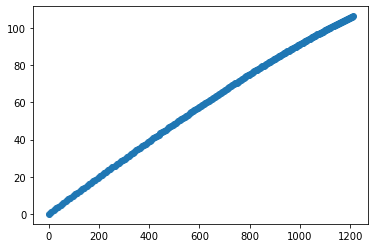

In [522]:
rkt = rocket(time_step=0.01)
rkt.velocity = np.array([1000.,100.])
for step in range(200):
    rkt.advance()
    if rkt.is_crashed():
        break
rkt.plot_trajectory()

In [506]:
rkt = rocket(time_step=0.01)

In [507]:
rkt.heading, rkt.velocity

(array([0., 1.]), array([0., 0.]))

In [508]:
rkt.fire()
rkt.advance()
rkt.heading, rkt.velocity

(array([0., 1.]), array([0.        , 0.27923617]))

In [509]:
rkt.stopwatch

0.01

In [510]:
initializer = keras.initializers.he_normal

#make a policy model
class pilot(keras.models.Sequential):
    def __init__(self, num_layers, layer_size):
        super().__init__()
        for layer in range(num_layers):
            self.add(
                keras.layers.Dense(
                                    layer_size,
                                    bias_initializer=initializer,
                                    kernel_initializer=initializer,
                                    activation = 'relu'
                                   )
                    )
        output = keras.layers.Dense(3, activation = 'softmax')
        self.add(output)
        
    def call(self, x, training = True):
        for layer in self.layers:
            x = layer(x, training = training)
        return tf.squeeze(x)

In [511]:
target_velocity = tf.constant([27400., 0.], dtype = 'float32') #m/s
target_altitude = tf.constant(200000., dtype = 'float32') #m

Attempt at gradient descent. 
---

I am having trouble figuring out how it tracks variables to perform the gradient calculation.

In [289]:
trials = 10

pil = pilot(2,8)
f_threshhold = 0.5
torque_threshhold = 0.5

loss_fn = tf.losses.Huber()
optimizer = tf.optimizers.Adam(learning_rate = 0.001)

time_steps = 100

#do a number of launches
for trial in range(trials):
    with tf.GradientTape() as tape:
        rkt = rocket()
        while not rkt.is_crashed():
            inputs = tf.convert_to_tensor([
                rkt.position[0],
                rkt.position[1],
                rkt.velocity[0],
                rkt.velocity[1],
                rkt.heading[0],
                rkt.heading[1]
            ])
            inputs = tf.expand_dims(inputs, 0)
            to_fire, to_torque_l, to_torque_r = pil.call(inputs)
            if to_fire >= f_threshhold:
                rkt.fire()
            if to_torque_l >= torque_threshhold:
                rkt.torque()
            if to_torque_r >- torque_threshhold:
                rkt.torque(clockwise = True)
            rkt.advance()
#         loss = rkt.position[1] - target_altitude + rkt.velocity - target_velocity
        loss = loss_fn([rkt.position[1]], [target_altitude])
        grads = tape.gradient(loss, pil.trainable_variables)
        optimizer.apply_gradients(zip(grads, pil.trainable_variables ))
        


ValueError: No gradients provided for any variable: (['dense_579/kernel:0', 'dense_579/bias:0', 'dense_580/kernel:0', 'dense_580/bias:0', 'dense_581/kernel:0', 'dense_581/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_579/kernel:0' shape=(6, 8) dtype=float32, numpy=
array([[ 0.4349669 , -0.15769735, -0.53152204,  0.62347513, -0.23621993,
        -0.37176245,  0.80117434, -1.1494744 ],
       [ 0.9479287 ,  0.24949442,  0.74867594,  0.31008676,  0.3826203 ,
        -0.12911877,  0.5513093 , -0.97001296],
       [-0.4715622 , -0.6357792 , -0.9691056 , -0.56582534,  0.45655093,
         0.69411105, -0.06838392,  1.0979421 ],
       [ 0.8292087 ,  0.05240438, -1.1567737 ,  0.6566499 , -0.09572027,
        -0.41941994,  0.9796081 ,  0.4624979 ],
       [ 1.1143063 ,  0.6230853 , -0.09383065, -1.0850912 ,  0.7612391 ,
         0.35137594, -0.49600297, -0.55574334],
       [ 0.7094954 , -0.8043795 , -0.705852  , -0.92822784, -1.0471447 ,
        -0.9183437 , -0.6838695 , -0.3683543 ]], dtype=float32)>), (None, <tf.Variable 'dense_579/bias:0' shape=(8,) dtype=float32, numpy=
array([ 0.47009933,  0.00846285,  1.0052902 , -0.14984603, -0.31124443,
        0.6559606 , -0.43837893, -0.601039  ], dtype=float32)>), (None, <tf.Variable 'dense_580/kernel:0' shape=(8, 8) dtype=float32, numpy=
array([[-0.42383546, -0.01349779, -0.05899413, -0.867805  , -0.81325984,
        -0.25187087, -0.31763867, -0.02261465],
       [-0.6865925 ,  0.5646537 , -0.10485242,  0.04388597, -0.48709673,
        -0.79942733, -0.4916474 , -0.06970227],
       [ 0.29310212,  0.07730658,  0.14215682,  1.01978   , -0.4237121 ,
         0.4713198 , -0.65652907, -0.26133248],
       [-0.40686193,  0.8400694 , -0.2797682 ,  0.4803206 , -0.5993695 ,
         0.01790223,  0.09619126, -0.42854252],
       [ 0.38052154,  0.03895736, -0.02036583,  0.92752683, -0.52966464,
        -0.77261305, -0.64830077,  0.28099164],
       [ 0.70054144, -0.8655246 , -0.12379222, -0.5011972 , -0.38212758,
        -0.8306342 , -0.43141317,  0.16931055],
       [-0.5598879 ,  0.83985543,  0.40820548, -0.21750258, -0.2871137 ,
        -0.75933045,  0.4230097 ,  0.596828  ],
       [-0.5569084 ,  0.70164233,  0.46899593, -0.58070403,  0.6347276 ,
         0.15740846, -0.15349819, -0.53707397]], dtype=float32)>), (None, <tf.Variable 'dense_580/bias:0' shape=(8,) dtype=float32, numpy=
array([-0.27471372,  0.36757746, -0.19209675, -0.15136048, -0.23302346,
       -0.3980784 ,  0.09476714, -0.50710195], dtype=float32)>), (None, <tf.Variable 'dense_581/kernel:0' shape=(8, 3) dtype=float32, numpy=
array([[-0.4828575 ,  0.00663644, -0.73166865],
       [-0.40012136, -0.42569628, -0.01536751],
       [ 0.4290368 , -0.03905433,  0.68477684],
       [-0.4002233 ,  0.0984509 , -0.17079866],
       [-0.00512666,  0.25663632, -0.58730173],
       [-0.63217264, -0.6208935 ,  0.37030596],
       [ 0.42374355, -0.49141797, -0.02151269],
       [ 0.28683203,  0.43995243,  0.1516046 ]], dtype=float32)>), (None, <tf.Variable 'dense_581/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>)).

genetic algorithm
---

No gradienttape needed.

In [523]:
#define goals
target_velocity = tf.constant([27400., 0.], dtype = 'float32') #m/s
target_altitude = tf.constant(200000., dtype = 'float32') #m

In [531]:
epochs = 10
epoch_update_period = 5
children_per_epoch = 5

f_threshhold = 0.5
torque_threshhold = 0.5

#make rng for weight adjustments
rng = np.random.default_rng()

#weight decay with time
decay_constant = 0.999
randomness_scale = 1


#make master pilot
pilot_shape = (1,8)
pilot_children = [
    pilot(1,8)
    for child in range(children_per_epoch)
]

dummy_inputs = tf.convert_to_tensor([
                0.,0.,0.,0.,0.,0.
            ])
for child in pilot_children:
    child.call(tf.expand_dims(dummy_inputs,0))

#do a number of launches
for epoch in range(epochs):
    randomness_scale = randomness_scale*decay_constant
    child_losses = []
    for child in pilot_children:
        #randomly adjust variables
        new_weights = []
        for weights in child.trainable_variables:
            this_shape = weights.shape
            new_weights.append(weights + rng.normal(loc=0.0, scale=randomness_scale, size=this_shape))
        child.set_weights(new_weights)
        #perform a simulation
        rkt = rocket(time_step = 2)
        while rkt.stopwatch < 120 and not rkt.is_crashed():
             
            rkt.fire()   #get state of rocket
            inputs = tf.constant([
                rkt.position[0],
                rkt.position[1],
                rkt.velocity[0],
                rkt.velocity[1],
                rkt.heading[0],
                rkt.heading[1]
            ])
            inputs = tf.expand_dims(inputs, 0)
                #create policy
            to_fire, to_torque_l, to_torque_r = child.call(inputs)
            if to_fire >= f_threshhold:
                rkt.fire()
            if to_torque_l >= torque_threshhold:
                rkt.torque()
            if to_torque_r >= torque_threshhold:
                rkt.torque(clockwise = True)
            rkt.advance()
        loss = abs(rkt.position[1] - tf.constant(target_altitude)) + np.linalg.norm(rkt.velocity - tf.constant(target_velocity))
        child_losses.append(loss)
    best_child = pilot_children[np.argmin(child_losses)]
    for child in pilot_children:
        child.set_weights(best_child.trainable_variables)
    
    if epoch%epoch_update_period == 0:
        print(f'epoch {epoch}: best loss: {np.min(child_losses)}, last command: {tf.convert_to_tensor([to_fire, to_torque_l, to_torque_r])}')
#         rkt.plot_trajectory()
    

epoch 0: best loss: 70695731200.0, last command: [1. 0. 0.]
epoch 5: best loss: 70695731200.0, last command: [1. 0. 0.]


In [405]:
to_fire, to_torque_l, to_torque_r

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [401]:
rkt.heading_history

[array([0., 1.]), array([0., 1.]), array([0., 1.])]

In [532]:
rkt.position_history

[array([0., 0.]),
 array([  0.        , 308.99553571]),
 array([  0.        , 699.08868697]),
 array([   0.        , 1151.07599124]),
 array([   0.        , 1646.39659806]),
 array([   0.       , 2170.0494151]),
 array([   0.        , 2711.48695663]),
 array([   0.        , 3264.05786725]),
 array([   0.        , 3823.91494882]),
 array([   0.        , 4388.98868764]),
 array([   0.        , 4958.23843948]),
 array([   0.        , 5531.17758124]),
 array([   0.       , 6107.5997445]),
 array([   0.        , 6687.43281611]),
 array([   0.       , 7270.6668652]),
 array([   0.        , 7857.32175482]),
 array([   0.        , 8447.43465655]),
 array([   0.       , 9041.0570001]),
 array([   0.        , 9638.25588659]),
 array([    0.        , 10239.11802798]),
 array([    0.        , 10843.75590524]),
 array([    0.        , 11452.31681988]),
 array([    0.        , 12064.99640497]),
 array([    0.        , 12682.05947341]),
 array([    0.        , 13303.87355444]),
 array([    0.        

In [533]:
np.linalg.norm(rkt.velocity - tf.constant(target_velocity))

70691815000.0

In [534]:
abs(rkt.position[1] - tf.constant(target_altitude))

<tf.Tensor: shape=(), dtype=float32, numpy=3917134.2>

In [ ]:
np.min()